In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats import diagnostic

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.simplefilter('ignore')

In [2]:
promotion = pd.read_csv('./promotion.csv')

In [3]:
promotion.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
# It's not going to influenced in any decision and might cause some model biased learning
promotion_cleaned = promotion.drop('employee_id', axis=1)

In [6]:
promotion_cleaned = promotion_cleaned.rename(columns = {'KPIs_met >80%':'kpis_met_80', 'awards_won?':'awards_won'})

In [7]:
promotion_cleaned.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
kpis_met_80                0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
# It seems that there are employees that might not have a previous perfomance rating over the last year, these employees shouldn't be considered to have a promotion

In [9]:
promotion_cleaned['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [10]:
filter_by_previous_rating = promotion_cleaned[promotion_cleaned['previous_year_rating'].isna()]
filter_by_previous_rating

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,1,0,88,0
54734,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,1,0,56,1
54746,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0


In [11]:
filter_by_previousrating_lengthservice = promotion_cleaned[(promotion_cleaned['previous_year_rating'].isna()) & (promotion_cleaned['length_of_service'] <= 1)]
filter_by_previousrating_lengthservice

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,1,0,88,0
54734,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,1,0,56,1
54746,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0


In [12]:
comparison = filter_by_previousrating_lengthservice.index == filter_by_previous_rating.index
set(comparison)

{True}

In [13]:
# promotion_cleaned = promotion_cleaned.drop(filter_by_previous_rating.index)

In [14]:
promotion_cleaned['previous_year_rating'] = promotion_cleaned['previous_year_rating'].fillna(0.0).reset_index(drop=True)

In [15]:
promotion_cleaned.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
kpis_met_80                0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [16]:
promotion_cleaned['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [17]:
promotion_cleaned[(promotion_cleaned['education'].isna()) & (promotion_cleaned['is_promoted'])]

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
323,Sales & Marketing,region_2,NaN,m,other,1,22,5.0,2,0,0,62,1
359,Sales & Marketing,region_28,NaN,m,other,1,24,2.0,2,1,0,52,1
574,Sales & Marketing,region_2,NaN,m,other,1,24,3.0,2,1,1,81,1
867,Sales & Marketing,region_28,NaN,m,other,1,25,4.0,3,1,0,64,1
1585,Sales & Marketing,region_28,NaN,m,other,1,34,5.0,7,1,0,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,Sales & Marketing,region_2,NaN,m,sourcing,1,24,4.0,3,1,1,92,1
53064,Sales & Marketing,region_2,NaN,m,other,1,32,5.0,5,1,0,48,1
53612,Sales & Marketing,region_22,NaN,m,other,1,24,4.0,2,0,0,98,1
53695,HR,region_2,NaN,m,sourcing,1,33,4.0,8,1,0,48,1


In [18]:
len(promotion_cleaned[(promotion_cleaned['education'].isna()) & (promotion_cleaned['is_promoted'])])/len(promotion_cleaned[promotion_cleaned['is_promoted']==1])

0.026135389888603255

In [19]:
promotion_cleaned.isna().mean() * 100

department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    0.000000
length_of_service       0.000000
kpis_met_80             0.000000
awards_won              0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [20]:
# Since the representation of nulls is about 4% of the entire dataset and 2% of the promoted employees I decided to cleansed this data.
# promotion_cleaned['education'] = promotion_cleaned['education'].fillna('not_specified').reset_index(drop=True)
promotion_cleaned = promotion_cleaned.dropna()

In [21]:
promotion_cleaned.isna().mean() * 100

department              0.0
region                  0.0
education               0.0
gender                  0.0
recruitment_channel     0.0
no_of_trainings         0.0
age                     0.0
previous_year_rating    0.0
length_of_service       0.0
kpis_met_80             0.0
awards_won              0.0
avg_training_score      0.0
is_promoted             0.0
dtype: float64

In [22]:
promotion_cleaned.nunique()

department               9
region                  34
education                3
gender                   2
recruitment_channel      3
no_of_trainings         10
age                     41
previous_year_rating     6
length_of_service       35
kpis_met_80              2
awards_won               2
avg_training_score      61
is_promoted              2
dtype: int64

In [23]:
# Dividing our dataset in numerical and categorical variables
prom_numerical = promotion_cleaned.select_dtypes(include='number')
prom_categorical = promotion_cleaned.select_dtypes(include='object')

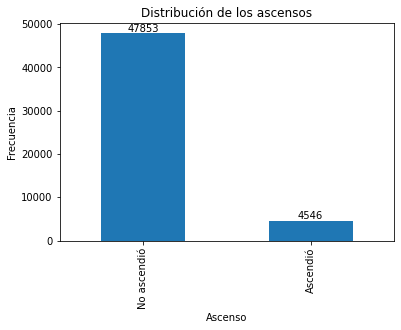

In [24]:
promotion_count = promotion_cleaned['is_promoted'].value_counts()
plot = promotion_count.plot.bar()
plt.title('Distribución de los ascensos')
plt.ylabel('Frecuencia')
plt.xlabel('Ascenso')
plt.xticks(range(2),['No ascendió', 'Ascendió'])

for p in plot.patches:
     plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

In [25]:
promotion_corr = prom_numerical.corr()
promotion_corr

,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.082601,-0.064135,-0.057845,-0.047344,-0.007659,0.041124,-0.025389
age,-0.082601,1.000000,0.170738,0.652379,-0.030967,-0.008209,-0.060652,-0.018920
previous_year_rating,-0.064135,0.170738,1.000000,0.183914,0.275608,0.021547,0.051217,0.126505
length_of_service,-0.057845,0.652379,0.183914,1.000000,-0.082109,-0.040140,-0.045329,-0.012167
kpis_met_80,-0.047344,-0.030967,0.275608,-0.082109,1.000000,0.095555,0.072899,0.219934
awards_won,-0.007659,-0.008209,0.021547,-0.040140,0.095555,1.000000,0.072069,0.195451
avg_training_score,0.041124,-0.060652,0.051217,-0.045329,0.072899,0.072069,1.000000,0.180489
is_promoted,-0.025389,-0.018920,0.126505,-0.012167,0.219934,0.195451,0.180489,1.000000


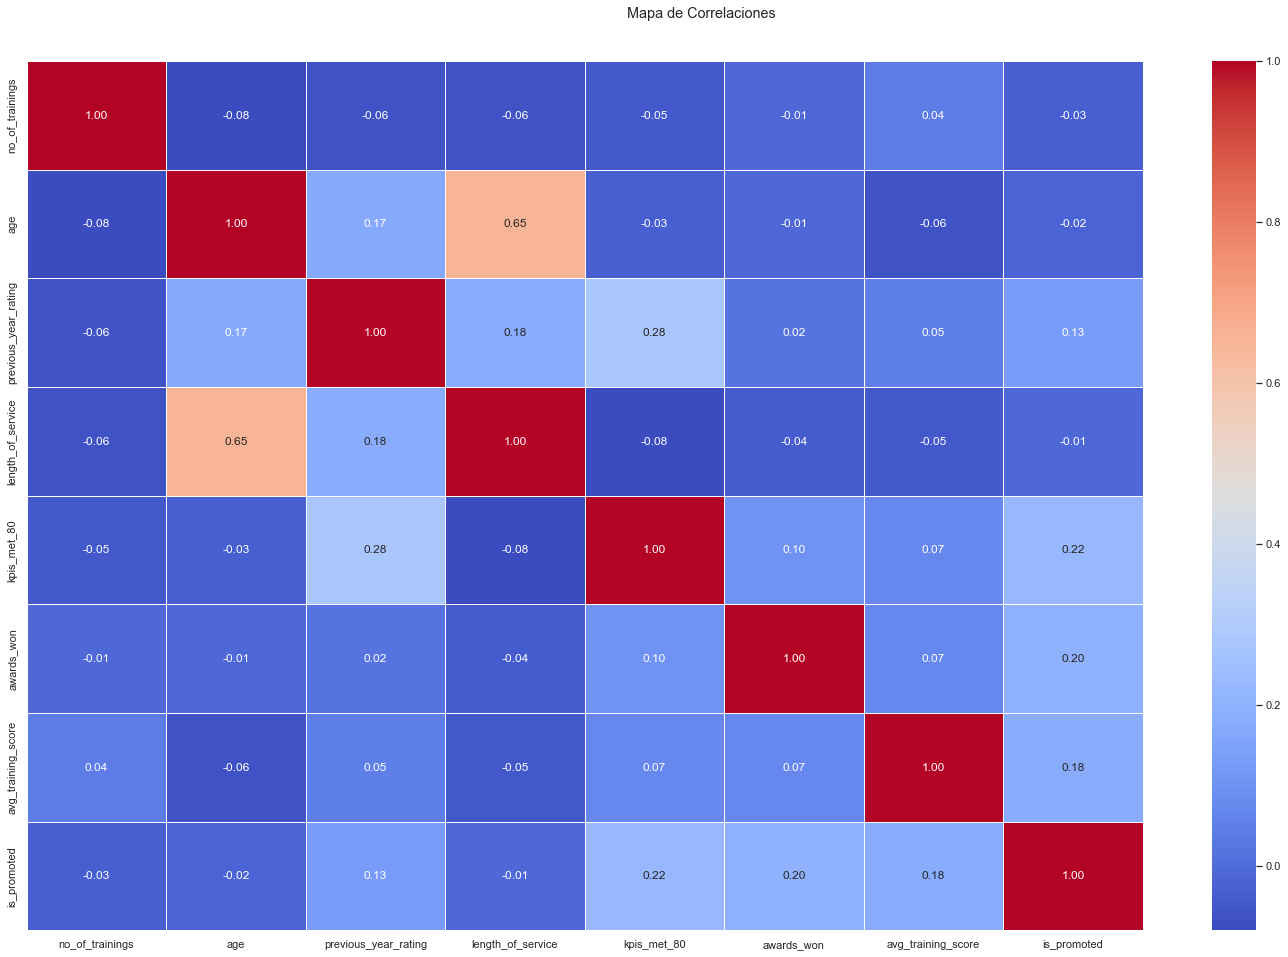

In [26]:
sns.set()

fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(round(promotion_corr, 2), annot=True, ax=ax, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
fig.subplots_adjust(top=0.93)
fig.suptitle('Mapa de Correlaciones');

(0.4694864024897663, 0.0009999999999998899)


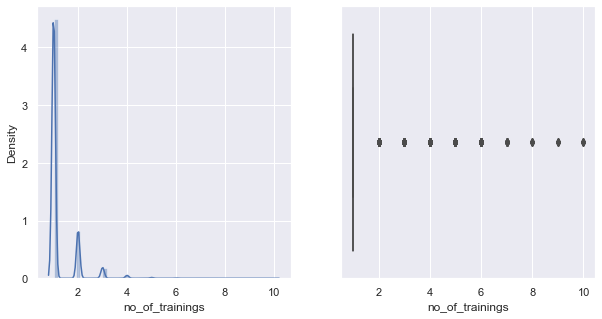


(0.1169401747075029, 0.0009999999999998899)


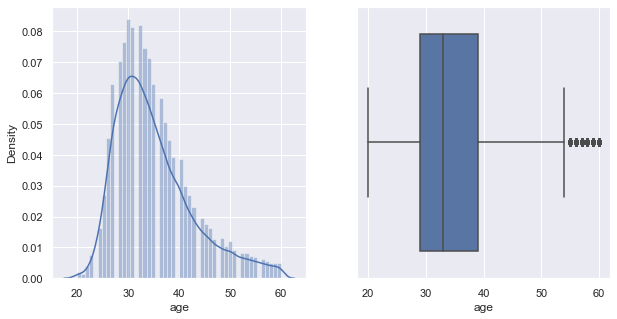


(0.21262700801267587, 0.0009999999999998899)


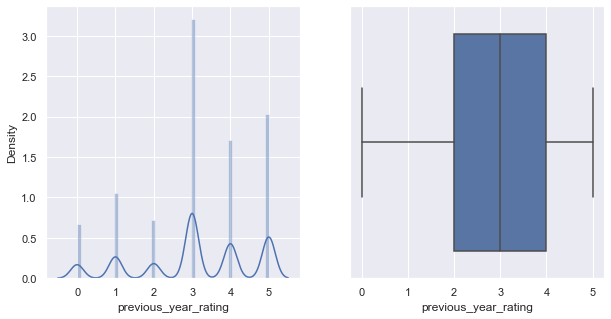


(0.14874866424066757, 0.0009999999999998899)


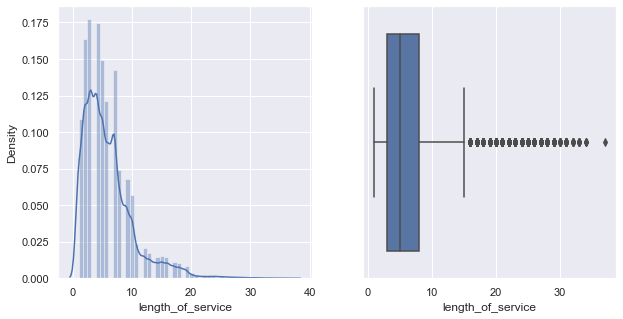


(0.4150010398798866, 0.0009999999999998899)


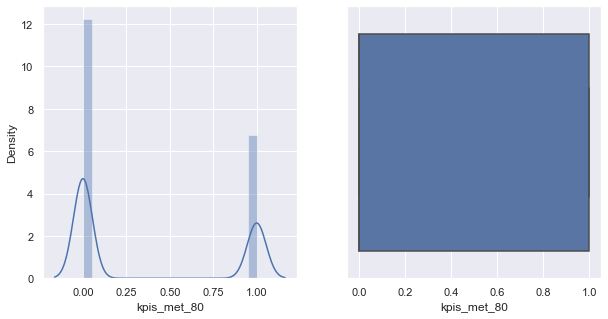


(0.5380285859290789, 0.0009999999999998899)


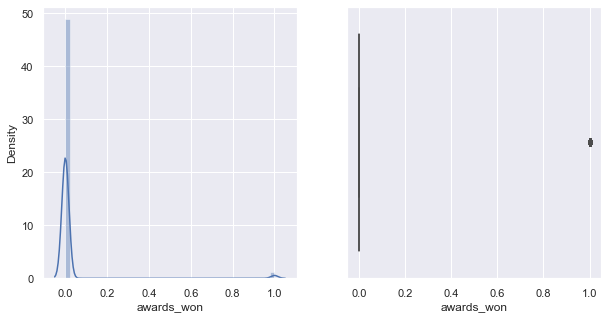


(0.11492079684535772, 0.0009999999999998899)


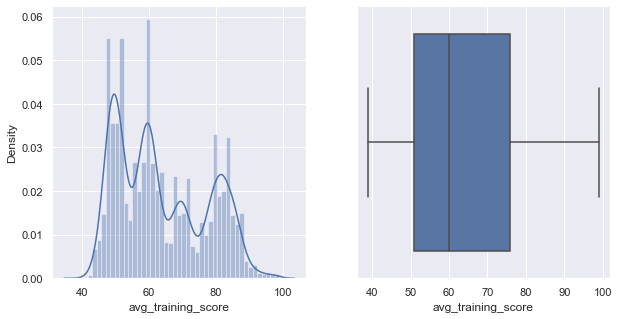


(0.5342838477137702, 0.0009999999999998899)


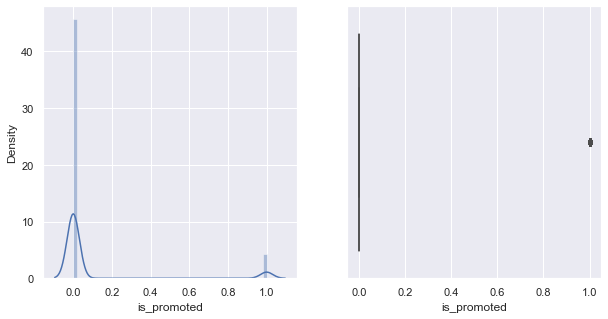

In [27]:
for column in prom_numerical:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(prom_numerical[column], kde=True, ax=ax[0])
    sns.boxplot(prom_numerical[column], orient='h', ax=ax[1])
    print(diagnostic.kstest_normal(prom_numerical[column]))
    plt.show()
    print('');

department   Analytics  Finance    HR  Legal  Operations  Procurement   R&D  \
is_promoted                                                                   
0                  0.9     0.92  0.94   0.95        0.91          0.9  0.93   
1                  0.1     0.08  0.06   0.05        0.09          0.1  0.07   

department   Sales & Marketing  Technology  
is_promoted                                 
0                         0.93        0.89  
1                         0.07        0.11  
AxesSubplot(0.125,0.125;0.775x0.755)
region       region_1  region_10  region_11  region_12  region_13  region_14  \
is_promoted                                                                    
0                 0.9       0.92       0.94       0.93       0.91       0.93   
1                 0.1       0.08       0.06       0.07       0.09       0.07   

region       region_15  region_16  region_17  region_18  ...  region_31  \
is_promoted                                              ...          

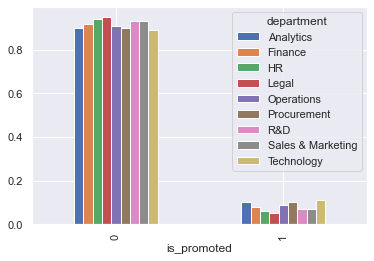

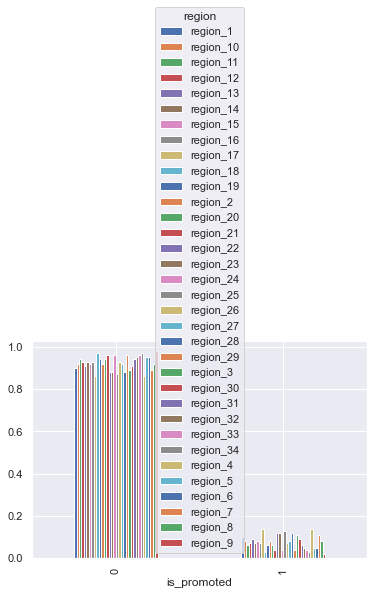

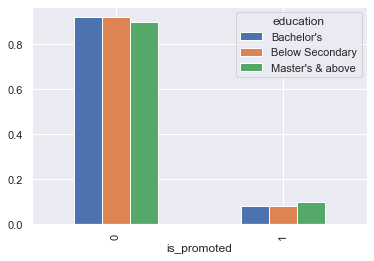

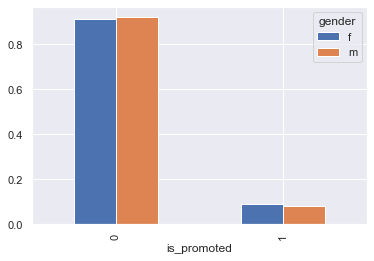

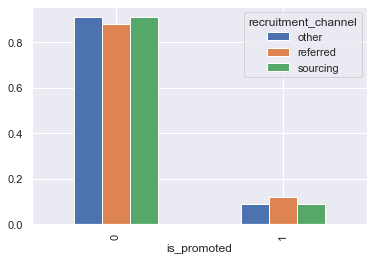

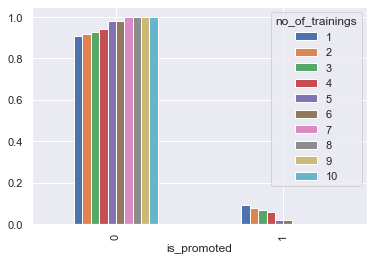

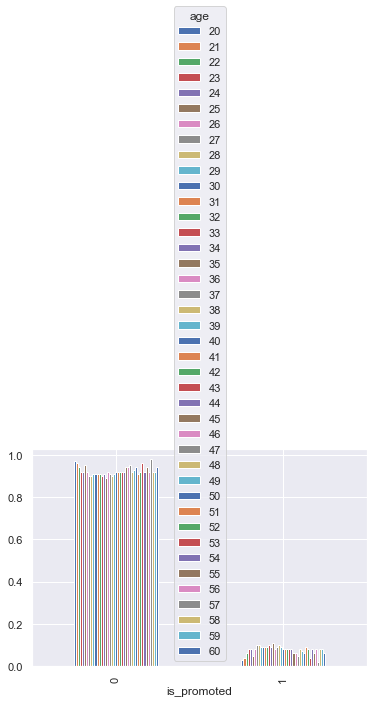

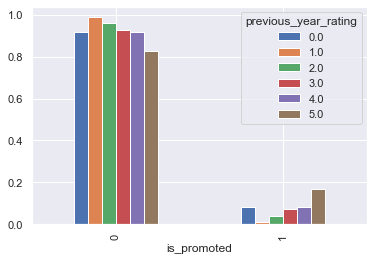

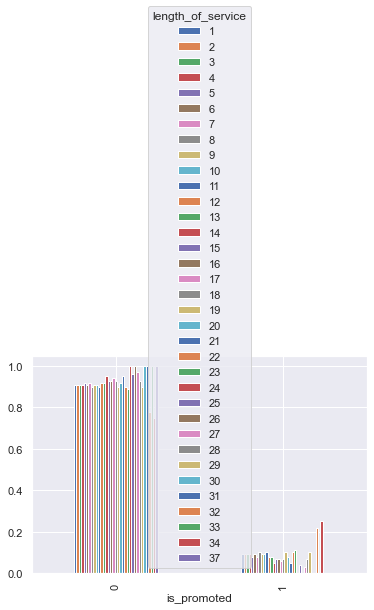

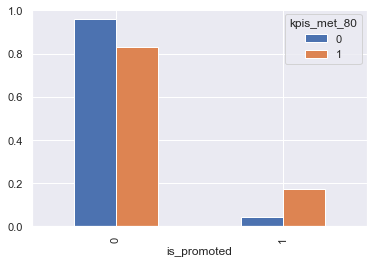

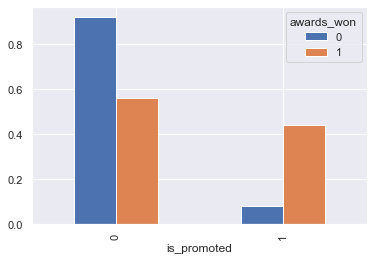

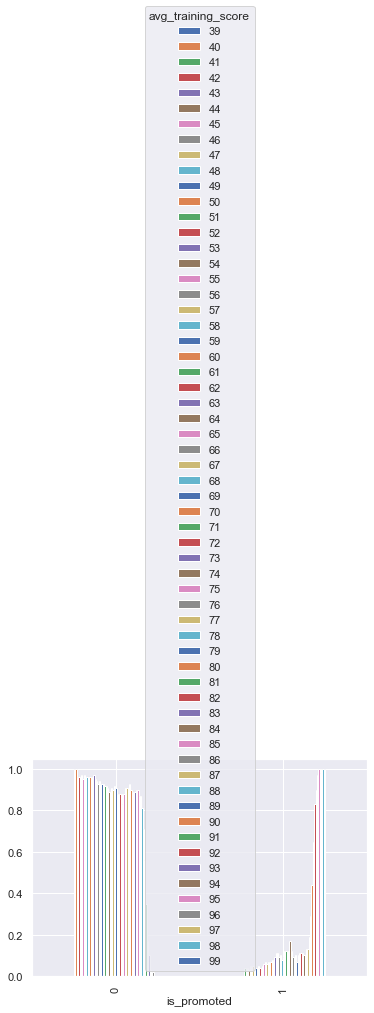

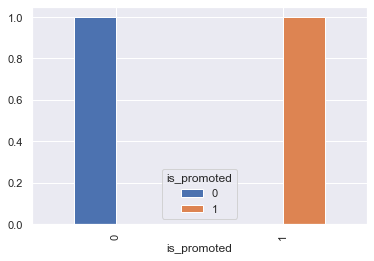

In [28]:
for column in promotion_cleaned:
    promo_by_group = pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned[column], normalize = 'columns')
    promo_by_group = promo_by_group.apply(lambda x: round(x,2))
    print(promo_by_group)
    print(promo_by_group.plot.bar())


In [29]:
# age_log = np.log1p(promotion_cleaned['age'])
# service_log = np.log1p(promotion_cleaned['length_of_service'])
# score_log = np.log1p(promotion_cleaned['avg_training_score'])

# promotion_cleaned.insert(6, 'age_log', age_log)
# promotion_cleaned.insert(9, 'length_of_service_log', service_log)
# promotion_cleaned.insert(12, 'avg_training_score_log', score_log)

# promotion_cleaned.head()

Sales & Marketing    15265
Operations           11122
Procurement           7066
Technology            7039
Analytics             5015
Finance               2500
HR                    2386
Legal                 1035
R&D                    971
Name: department, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
region_2     11497
region_22     6108
region_7      4624
region_15     2617
region_13     2592
region_26     2160
region_31     1841
region_4      1701
region_27     1575
region_16     1410
region_11     1291
region_28     1234
region_23     1147
region_29      975
region_19      864
region_32      861
region_20      849
region_14      804
region_17      787
region_25      785
region_5       759
region_6       676
region_10      644
region_30      644
region_8       642
region_1       596
region_24      507
region_12      498
region_21      403
region_9       372
region_3       344
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64
AxesSubplot(0.12

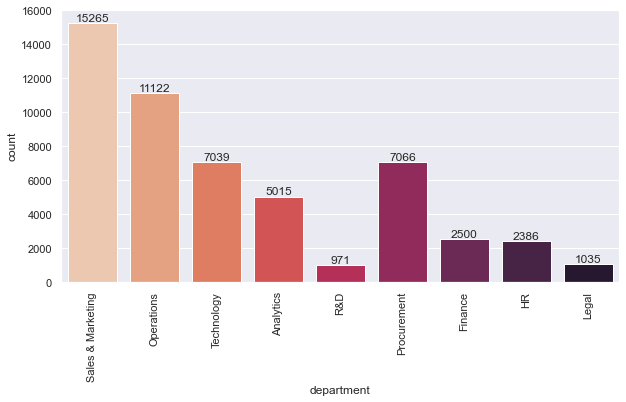

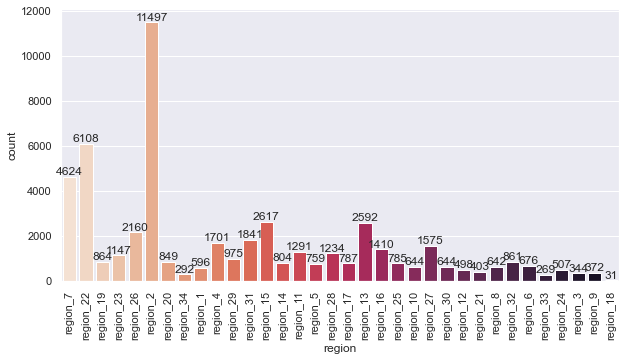

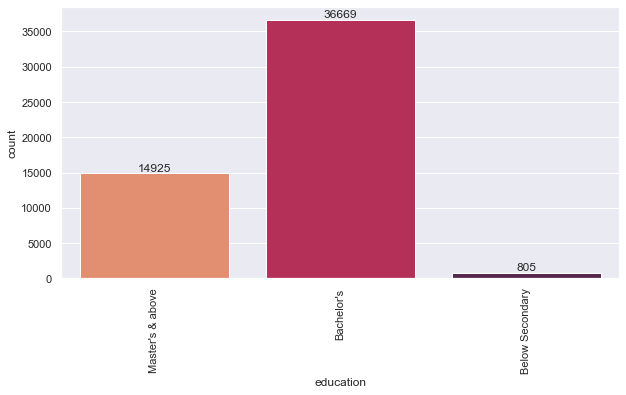

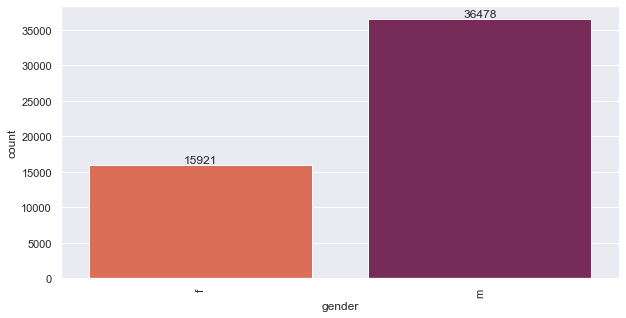

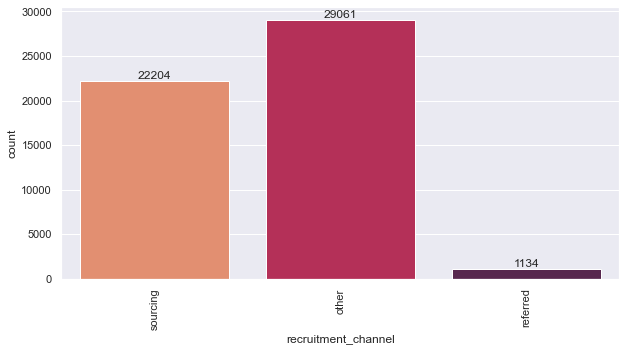

In [30]:
for column in prom_categorical:
    plt.figure(figsize = (10, 5))
    print(prom_categorical[column].value_counts())
    plot = sns.countplot(x = column, data = promotion_cleaned, palette='rocket_r')
    print(plot)
    sns.color_palette("magma", as_cmap=True)
    plt.xticks(rotation = 90)
    for p in plot.patches:
         plot.annotate(p.get_height(), 
                            (p.get_x() + p.get_width() / 2.0, 
                             p.get_height()), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

<AxesSubplot:xlabel='gender,is_promoted'>

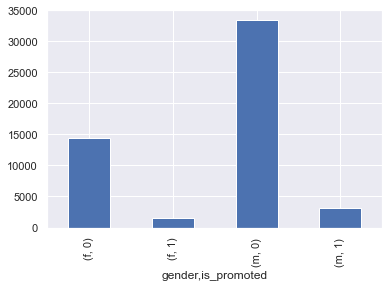

In [31]:
promotion_cleaned.groupby(['gender', 'is_promoted'])['is_promoted'].count().plot(kind='bar')

<AxesSubplot:xlabel='awards_won,is_promoted'>

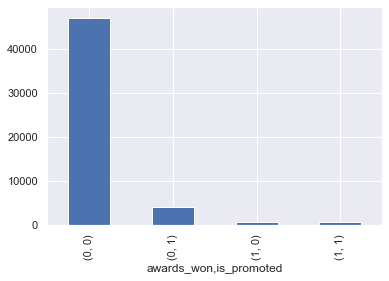

In [32]:
promotion_cleaned.groupby(['awards_won', 'is_promoted'])['awards_won'].count().plot(kind='bar')

In [33]:
promotion_cleaned.groupby('kpis_met_80')['kpis_met_80'].count()

kpis_met_80
0    33703
1    18696
Name: kpis_met_80, dtype: int64

In [34]:
promotion_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52399 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            52399 non-null  object 
 1   region                52399 non-null  object 
 2   education             52399 non-null  object 
 3   gender                52399 non-null  object 
 4   recruitment_channel   52399 non-null  object 
 5   no_of_trainings       52399 non-null  int64  
 6   age                   52399 non-null  int64  
 7   previous_year_rating  52399 non-null  float64
 8   length_of_service     52399 non-null  int64  
 9   kpis_met_80           52399 non-null  int64  
 10  awards_won            52399 non-null  int64  
 11  avg_training_score    52399 non-null  int64  
 12  is_promoted           52399 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.6+ MB


In [35]:
len(promotion_cleaned['region'].unique())

34

In [36]:
region_map = promotion_cleaned['region'].value_counts().to_dict()

promotion_cleaned['region']=promotion_cleaned['region'].map(region_map)
promotion_cleaned.head(20)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
0,Sales & Marketing,4624,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,6108,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,864,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,1147,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,2160,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
5,Analytics,11497,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0
6,Operations,849,Bachelor's,f,other,1,31,3.0,5,0,0,59,0
7,Operations,292,Master's & above,m,sourcing,1,33,3.0,6,0,0,63,0
8,Analytics,849,Bachelor's,m,other,1,28,4.0,5,0,0,83,0
9,Sales & Marketing,596,Master's & above,m,sourcing,1,32,5.0,5,1,0,54,0


In [37]:
promotion_cleaned['education'] = promotion_cleaned['education'].replace({"not_specified":4, "Master's & above":3,"Bachelor's":2,'Below Secondary':1})
promotion_cleaned['education'].unique()

array([3, 2, 1])

In [38]:
promotion_cleaned['department'].value_counts()
labels_ordered_by_mean = promotion_cleaned.groupby(['department'])['is_promoted'].mean().sort_values().index
labels_ordered_by_mean_dict = {k:v for v,k in enumerate(labels_ordered_by_mean)}
promotion_cleaned['department'] = promotion_cleaned['department'].map(labels_ordered_by_mean_dict)
promotion_cleaned['department'].unique()

array([3, 5, 8, 6, 2, 7, 4, 1, 0])

<AxesSubplot:>

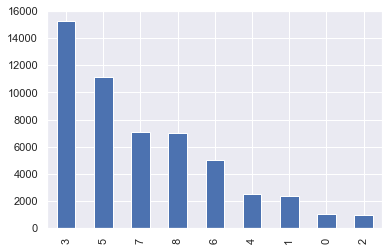

In [39]:
promotion_cleaned['department'].value_counts().plot(kind='bar')

In [40]:
promotion_cleaned_dummies = pd.get_dummies(promotion_cleaned, drop_first=True)
promotion_cleaned_dummies

,department,region,education,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,3,4624,3,1,35,5.0,8,1,0,49,0,0,0,1
1,5,6108,2,1,30,5.0,4,0,0,60,0,1,0,0
2,3,864,2,1,34,3.0,7,0,0,50,0,1,0,1
3,3,1147,2,2,39,1.0,10,0,0,50,0,1,0,0
4,8,2160,2,1,45,3.0,2,0,0,73,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,3,804,2,2,31,1.0,2,0,0,49,0,1,0,0
54803,8,804,2,1,48,3.0,17,0,0,78,0,1,0,1
54804,5,1575,3,1,37,2.0,6,0,0,56,0,0,0,0
54805,6,596,2,1,27,5.0,3,1,0,79,0,1,0,0


In [41]:
dummies_corr = promotion_cleaned_dummies.drop(['age','length_of_service', 'avg_training_score'], axis=1).corr()
dummies_corr

,department,region,education,no_of_trainings,previous_year_rating,kpis_met_80,awards_won,is_promoted,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
department,1.000000,-0.011720,0.033672,0.041909,0.027976,0.055925,0.009905,0.050322,-0.136100,0.027866,-0.004394
region,-0.011720,1.000000,0.027583,0.083463,0.020478,0.019912,-0.004803,0.013237,-0.113232,0.134235,-0.000712
education,0.033672,0.027583,1.000000,-0.037147,0.118358,0.001250,0.000495,0.025438,-0.017288,-0.036450,-0.000836
no_of_trainings,0.041909,0.083463,-0.037147,1.000000,-0.064135,-0.047344,-0.007659,-0.025389,0.086654,-0.014653,-0.009306
previous_year_rating,0.027976,0.020478,0.118358,-0.064135,1.000000,0.275608,0.021547,0.126505,-0.020105,0.044870,-0.003417
kpis_met_80,0.055925,0.019912,0.001250,-0.047344,0.275608,1.000000,0.095555,0.219934,-0.035893,0.047196,-0.007046
awards_won,0.009905,-0.004803,0.000495,-0.007659,0.021547,0.095555,1.000000,0.195451,0.002721,0.003249,-0.006785
is_promoted,0.050322,0.013237,0.025438,-0.025389,0.126505,0.219934,0.195451,1.000000,-0.010575,0.018459,-0.000050
gender_m,-0.136100,-0.113232,-0.017288,0.086654,-0.020105,-0.035893,0.002721,-0.010575,1.000000,0.008714,0.003989
recruitment_channel_referred,0.027866,0.134235,-0.036450,-0.014653,0.044870,0.047196,0.003249,0.018459,0.008714,1.000000,-0.127539


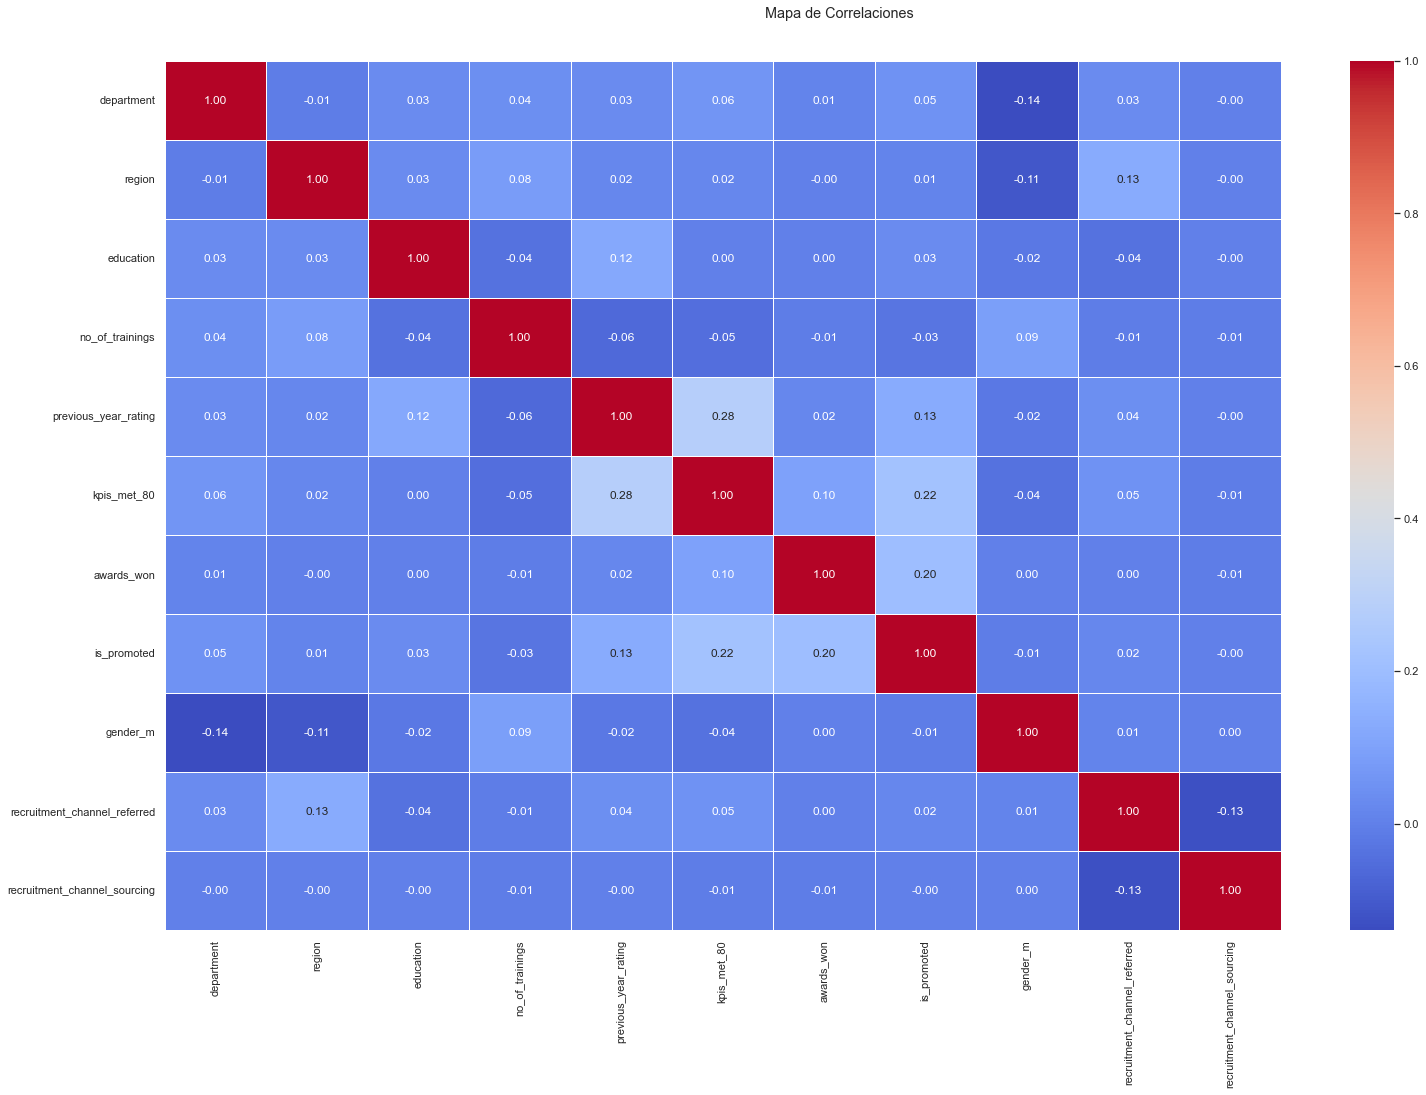

In [42]:
sns.set()

fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(round(dummies_corr, 2), annot=True, ax=ax, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
fig.subplots_adjust(top=0.93)
fig.suptitle('Mapa de Correlaciones');


In [43]:
X = promotion_cleaned_dummies.drop(['age','length_of_service', 'avg_training_score'], axis=1)
y = promotion_cleaned_dummies[['is_promoted']]

print(y.value_counts())

is_promoted
0              47853
1               4546
dtype: int64


In [44]:
# Standardization of data #


PredictorScaler=StandardScaler()
# PredictorScaler=MinMaxScaler()

PredictorScalerFit = PredictorScaler.fit(X)

X =  PredictorScalerFit.transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# sm_smote = SMOTE()
sm_under = RandomUnderSampler(sampling_strategy=0.75)

# X_train, y_train = sm_smote.fit_resample(X_train, y_train)
X_train, y_train = sm_under.fit_resample(X_train, y_train)


# X_test, y_test = sm_smote.fit_resample(X_test, y_test)
X_test, y_test = sm_under.fit_resample(X_test, y_test)


(unique, counts)= np.unique(y_train, return_counts=True)
print((unique, counts))

counts[1]/counts[0]

(array([0, 1]), array([4818, 3614]))


0.7501037775010377

In [46]:
len(y_train[y_train==0]), len(y_train[y_train==1])

(4818, 3614)

In [47]:
# Logistic Regression

lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)


print(classification_report(y_train, lr_clf.predict(X_train)))
print(confusion_matrix(y_train, lr_clf.predict(X_train)))

print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4818
           1       1.00      1.00      1.00      3614

    accuracy                           1.00      8432
   macro avg       1.00      1.00      1.00      8432
weighted avg       1.00      1.00      1.00      8432

[[4818    0]
 [   0 3614]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00       932

    accuracy                           1.00      2174
   macro avg       1.00      1.00      1.00      2174
weighted avg       1.00      1.00      1.00      2174

[[1242    0]
 [   0  932]]


In [48]:
#Decision Trees

dtree_clf = DecisionTreeClassifier(max_depth=8)
dtree_fit = dtree_clf.fit(X_train,y_train)

y_pred2 = dtree_fit.predict(X_test) 


print(classification_report(y_train, dtree_fit.predict(X_train)))
print(confusion_matrix(y_train, dtree_fit.predict(X_train)))
print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

print(dtree_fit.score(X_test, y_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4818
           1       1.00      1.00      1.00      3614

    accuracy                           1.00      8432
   macro avg       1.00      1.00      1.00      8432
weighted avg       1.00      1.00      1.00      8432

[[4818    0]
 [   0 3614]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00       932

    accuracy                           1.00      2174
   macro avg       1.00      1.00      1.00      2174
weighted avg       1.00      1.00      1.00      2174

[[1242    0]
 [   0  932]]
1.0


In [49]:
#Random Forest
forest = RandomForestClassifier(max_depth=4, n_jobs=-1) # n_estimators = # de árboles
forest_fit = forest.fit(X_train, y_train) 
forest_fit

RandomForestClassifier(max_depth=4, n_jobs=-1)

In [50]:
y_pred3 = forest_fit.predict(X_test)

In [51]:
print(classification_report(y_train, forest_fit.predict(X_train)))
print(confusion_matrix(y_train, forest_fit.predict(X_train)))
print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

print(dtree_fit.score(X_test, y_test))

print(precision_score(y_test,y_pred3 ))
print(recall_score(y_test,y_pred3 ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4818
           1       1.00      1.00      1.00      3614

    accuracy                           1.00      8432
   macro avg       1.00      1.00      1.00      8432
weighted avg       1.00      1.00      1.00      8432

[[4818    0]
 [   0 3614]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00       932

    accuracy                           1.00      2174
   macro avg       1.00      1.00      1.00      2174
weighted avg       1.00      1.00      1.00      2174

[[1242    0]
 [   0  932]]
1.0
1.0
1.0


In [52]:
model_params = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params' : {
#             'criterion' : ['gini', 'entropy'],
#             'min_samples_split': [1, 2, 3],
#             'min_samples_leaf' : [1, 2, 3]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
#             'n_estimators': [i for i in range(100,800,200)],
#             'criterion' : ['gini', 'entropy'],
#             'max_features' : ['auto', 'sqrt'],
#             'n_jobs' : [-1]
        }
    },
    'logistic_reggresion' : {
        'model': LogisticRegression(),
        'params': {
#             'solver': ['lbfgs', 'sag', 'saga'],
        }
    }
}

In [53]:
scores = []

start = datetime.now()

for model_name, model_attributes in model_params.items():
    grid_clf =  GridSearchCV(model_attributes['model'], model_attributes['params'], cv=5, return_train_score=False)
    grid_clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid_clf.best_score_,
        'best_params': grid_clf.best_params_
    })
end = datetime.now()
print(end-start)
results = pd.DataFrame(scores,columns=['model','best_score','best_params'])
results




0:00:01.548679


,model,best_score,best_params
0,DecisionTree,1.0,{}
1,random_forest,1.0,{}
2,logistic_reggresion,1.0,{}


In [54]:
hyper_random_forest = results.loc[1,]['best_params']

In [55]:
random_forest2 = RandomForestClassifier(**hyper_random_forest)

In [56]:
forest_fit2 = random_forest2.fit(X_train, y_train) 
forest_fit2

RandomForestClassifier()

In [57]:
y_pred4 = forest_fit2.predict(X_test)


In [58]:
print(classification_report(y_test, y_pred4))
print(confusion_matrix(y_test, y_pred4))

print(dtree_fit.score(X_test, y_test))
print(precision_score(y_test,y_pred4 ))
print(recall_score(y_test,y_pred4 ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00       932

    accuracy                           1.00      2174
   macro avg       1.00      1.00      1.00      2174
weighted avg       1.00      1.00      1.00      2174

[[1242    0]
 [   0  932]]
1.0
1.0
1.0


In [59]:
hyperparameters_dtree = results.loc[0,]['best_params']


In [60]:
dtree_clf_2 = DecisionTreeClassifier(**hyperparameters_dtree)

In [61]:
Dtree2_fit = dtree_clf_2.fit(X_train, y_train) 
Dtree2_fit

DecisionTreeClassifier()

In [62]:
y_pred5 = Dtree2_fit.predict(X_test)

In [63]:
print('------'* 10)
print()

print(classification_report(y_test, y_pred5))
print(confusion_matrix(y_test, y_pred5))

print(dtree_fit.score(X_test, y_test))
print(precision_score(y_test,y_pred5 ))
print(recall_score(y_test,y_pred5))

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00       932

    accuracy                           1.00      2174
   macro avg       1.00      1.00      1.00      2174
weighted avg       1.00      1.00      1.00      2174

[[1242    0]
 [   0  932]]
1.0
1.0
1.0
